## Inladen

In [12]:
import re
import os
import glob
import html
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

import seaborn as sb
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import output_file
from bokeh.palettes import Accent
output_notebook()

Loading BokehJS ...

In [2]:
LACUNA = re.compile(r'\.\.+')

def load_file(path):
    with open(path) as f:
        xml_text = f.read()
    
    xml_text = xml_text.replace('&oudpond;', '')
    xml_text = xml_text.replace('&supm;', 'm')
    xml_text = xml_text.replace('&supM;', 'm')
    xml_text = xml_text.replace('&supc;', 'c')
    xml_text = xml_text.replace('&supt;', 't')
    xml_text = xml_text.replace('&supn;', 'n')
    xml_text = xml_text.replace('&sups;', 's')
    xml_text = xml_text.replace('&supd;', 'd')
    xml_text = xml_text.replace('&supc;', 'c')
    xml_text = xml_text.replace('&uring;', 'u')
    xml_text = xml_text.replace('&lt;', '')
    xml_text = xml_text.replace('&gt;', '')
    xml_text = html.unescape(xml_text)

    soup = BeautifulSoup(xml_text)
    
    data = {}

    # extract metadata:
    data['id'] = os.path.basename(path).replace('.xml', '')
    data['title'] = soup.find('title').text
    data['author'] = soup.find('author').text
    
    postquem = '<UNK>'
    try:
        postquem = soup.find('interpgrp', {'type': 'witnessYear_from'})
        postquem = postquem.find('interp')['value']
    except AttributeError:
        pass
    
    antequem = '<UNK>'
    try:
        antequem = soup.find('interpgrp', {'type': 'witnessYear_to'})
        antequem = antequem.find('interp')['value']
    except AttributeError:
        pass
    
    data['date'] = f'{postquem}-{antequem}'
    
    provenance = '<UNK>'
    try:
        provenance = soup.find('interpgrp', {'type': 'corpusProvenance'})
        provenance = provenance.find('interp')['value']
    except AttributeError:
        pass
    data['provenance'] = provenance
    
    # extract and clean lines:
    lines = []
    for line in soup.find_all('l'):
        text = line.get_text().strip()
        if text and not re.search(LACUNA, text):
            line = ''.join([c for c in text if c.isalpha() or c.isspace()]).strip()
            if line:
                lines.append(line)
    
    data['size'] = len(lines)
    data['lines'] = '\n'.join(lines)
    
    return data

In [3]:
texts = []
for fn in tqdm(glob.glob('../data/texts/rijm/*.xml')):
    texts.append(load_file(fn))

100%|██████████| 262/262 [00:34<00:00,  7.49it/s]


Add Gysseling-texts (enkel berijmde literaire teksten):

In [4]:
for fn in tqdm(glob.glob('../data/texts/gysseling_lit/*.xml')):
    with open(fn) as f:
        text = f.read()
    
    # metadata
    data = {}
    data['id'] = os.path.basename(fn).replace('.xml', '')
    data['title'] = re.findall(r'\<bron_oms\>(.*)\<\/bron_oms\>', text)[0]
    postquem = re.findall(r"jaar\_tot\=\'([0-9]+)'", text)[0]
    antequem = re.findall(r"jaar\_van\=\'([0-9]+)'", text)[0]
    data['date'] = f'{postquem}-{antequem}'
    
    data['provenance'] = 'Gyss.'
    data['author'] = '<UNK>'
    
    lines = []
    for line in text.split('\n'):
        line = line.strip()
        if not line:
            continue
        line = line.replace('<A >', '').replace('</A>', '')
        if not line or re.search(LACUNA, line):
            continue
        
        clean = ''
        for word in re.findall(r'<C ([0-9#\*@\+]+)_([^>]+)>\s*([^ \n\t\r<]+)', line):
            word = word[-1]
            word = ''.join([c for c in word if c.isalpha() or c.isspace()]).strip()
            if word:
                clean += word + ' '
        clean = clean.strip()
        if clean:
            lines.append(clean)
    
    data['size'] = len(lines)
    data['lines'] = '\n'.join(lines)
    
    texts.append(data)

100%|██████████| 21/21 [00:01<00:00, 19.78it/s]


## Rauwe aanpak

In [5]:
metadata, lines = [], []
for text in texts:
    lines.append(text['lines'])
    d = {d:text[d] for d in text if d != 'lines'}
    metadata.append(d)

In [6]:
vectorizer = TfidfVectorizer(max_features=10000, token_pattern=r'(?u)\b\w+\b')
X = vectorizer.fit_transform(lines).toarray()
print(X.shape)

(283, 10000)


In [7]:
pca = PCA(2)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(283, 2)


In [8]:
num_clust = 6

clust = AgglomerativeClustering(num_clust)
labels = clust.fit_predict(X_pca)

In [9]:
colors = [Accent[num_clust][i] for i in labels]

In [10]:
data_dict = {'x': X_pca[:, 0],
             'y': X_pca[:, 1],
             'color': colors,
             'Title': [d['title'] for d in metadata],
             'Author': [d['author'] for d in metadata],
             'Date': [d['date'] for d in metadata],
             'Length': [d['size'] for d in metadata],
             'loglen': [np.log(d['size']) for d in metadata],
}
data_df = pd.DataFrame(data_dict)

x_label = "PC 1"
y_label = "PC 2"
fig_title = "Cd-rom Middelnederlands (rijm)"

In [22]:
source = ColumnDataSource(data_dict)

p = figure(
    tools="hover,pan,wheel_zoom,save",
    toolbar_location="above",
    title=fig_title,
    plot_width=800, plot_height=800,
)

from bokeh.models import Label
for x, y, title in zip(data_dict['x'], data_dict['y'], data_dict['Title']):
    if 'reynaerde' in title.lower():
        p.add_layout(Label(x=x, y=y, text=title,
                           text_align="center", text_font_size="10pt"))

p.circle('x', 'y', source=source,
          fill_color='color', fill_alpha=1,
          line_color='grey', size='loglen')


p.xaxis.axis_label = x_label
p.yaxis.axis_label = y_label

p.hover.tooltips = [("Title", "@Title"),
                    ("Author", "@Author"),
                    ("Date", "@Date")]

show(p)
output_file("../output/pca.html")

We krijgen mooi de driehoek van Petersen: lyriek vs epiek vs dramatiek.

## TSNE (on top of PCA)

In [23]:
pca = PCA(30)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(283, 30)


In [24]:
tsne = TSNE(2)
X_tsne = tsne.fit_transform(X_pca)
print(X_tsne.shape)

(283, 2)


In [25]:
clust = AgglomerativeClustering(num_clust)
labels = clust.fit_predict(X_tsne)

In [26]:
colors = [Accent[num_clust][i] for i in labels]

In [27]:
data_dict = {'x': X_tsne[:, 0],
             'y': X_tsne[:, 1],
             'color': colors,
             'Title': [d['title'] for d in metadata],
             'Author': [d['author'] for d in metadata],
             'Date': [d['date'] for d in metadata],
             'Length': [d['size'] for d in metadata],
             'loglen': [np.log(d['size']) for d in metadata],
}
data_df = pd.DataFrame(data_dict)

x_label = "Dim. 1"
y_label = "Dim. 2"
fig_title = "Cd-rom Middelnederlands (rijm)"

In [28]:
source = ColumnDataSource(data_dict)

p = figure(
    tools="hover,pan,wheel_zoom,save",
    toolbar_location="above",
    title=fig_title,
    plot_width=800, plot_height=800,
)

from bokeh.models import Label
for x, y, title in zip(data_dict['x'], data_dict['y'], data_dict['Title']):
    if 'reynaerde' in title.lower():
        p.add_layout(Label(x=x, y=y, text=title,
                           text_align="center", text_font_size="10pt"))

p.circle('x', 'y', source=source,
          fill_color='color', fill_alpha=1,
          line_color='grey', size='loglen')


p.xaxis.axis_label = x_label
p.yaxis.axis_label = y_label

p.hover.tooltips = [("Title", "@Title"),
                    ("Author", "@Author"),
                    ("Date", "@Date")]

show(p)
output_file("../output/tsne.html")

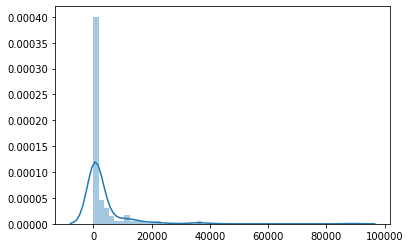

In [22]:
sb.distplot([d['size'] for d in metadata])

## Tagging

Dump raw texts for tagging using `pie`:

```python
outdir = '../data/tagging/raw'

try:
    shutil.rmtree(outdir)
except FileNotFoundError:
    pass

os.mkdir(outdir)
```

```python
for entry in texts:
    new_fn = os.path.basename(entry['id'] + '.tsv')
    with open(f'{outdir}/{new_fn}', 'w') as f:
        lines = entry['lines'].split('\n')
        for line in lines:
            f.write(' '.join(line.strip().split()) + '\n')
```